In [1]:
from fastai import *
from fastai.vision import *
from PIL import *

import colorcet as cc
cmap_grey = cc.cm.linear_grey_0_100_c0

# Demonstration of  speed and correctness of conversion of PIL Images to tensors

The result is that the proposed method "allPil2tensor" can handle both rgb and 16bit gray images correct

The existing method "Pil2tensor" can only handle jpg images/ 8 bit images

The proposed method is also slighty faster if we include the following conversion of float that takes place in open_image

In [2]:
# generate a test imag
arr = np.random.randint(0, 2**8-1, (224, 224, 3), dtype=np.uint8)  # or np.ones etc.
img = Image.fromarray(np.asarray(arr))

# The Pil2tensor methods

In [3]:
# the existing method
def Pil2tensor_old(image:NPImage)->TensorImage:
    "handles numpy of rgb only - Convert PIL style `image` array to torch style image tensor."
    arr = ByteTensor(torch.ByteStorage.from_buffer(image.tobytes()))
    arr = arr.view(image.size[1], image.size[0], -1)
    return arr.permute(2,0,1)


In [4]:
from numpy import ndarray
NDArray = ndarray
def pil2tensor_new(image:Union[NPImage,NDArray], dtype)->TensorImage:
    #image: must be a PIL.image or a numpy array. 
    #       Grayscale (single channel) convert to the shape: 1, heigh, widt
    #       rgb converts to a shape of:                      3, width, height
    #dtype: pytorch support: np.double, np.float16, np.int64, np.int32, and np.uint8
    "Convert PIL.Image or numpy.ndarray to a torch tensor formattet for input to a neural network."
    "Usage 1: pil2tensor(Image.open(\"dog.47.jpg\").convert(fmt), dtype).div_(scale)"
    "         where fmt = RGB, L (=8bit for fx masks) or I (= int for fx 16 bit grayscale)"
    "         where scale = 255 for rgb, 65535 for grayscale"
    "         if your data are already at the right scale then no .div is required"
    "Usage 2: if your image is a simple rgb of grayscale the you can do. The following is slightly faster but more risky"
    "         pil2tensor(Image.open(\"dog.47.jpg\"), dtype).div_(scale) with scale as above. "
    "Usage 3: pil2tensor(Image.open(numpy_array,dtype), dtype).div_(scale) if data alredy are in a numpy array"
    a = np.asarray(image)
    if a.ndim==2 : a = np.expand_dims(a,2)    
    a = np.transpose(a, (1, 0, 2))  #transpose width, height to height,width
    a = np.transpose(a, (2, 1, 0))  #move channels to the first positionf
    return torch.from_numpy( a.astype(dtype, copy=False) )

def pil2tensor_radek(image:Union[NPImage,NDArray], dtype)->TensorImage:
    #image: must be a PIL.image or a numpy array. 
    #       Grayscale (single channel) convert to the shape: 1, heigh, widt
    #       rgb converts to a shape of:                      3, width, height
    #dtype: pytorch support: np.double, np.float16, np.int64, np.int32, and np.uint8
    "Convert PIL.Image or numpy.ndarray to a torch tensor formattet for input to a neural network."
    "Usage 1: pil2tensor(Image.open(\"dog.47.jpg\").convert(fmt), dtype).div_(scale)"
    "         where fmt = RGB, L (=8bit for fx masks) or I (= int for fx 16 bit grayscale)"
    "         where scale = 255 for rgb, 65535 for grayscale"
    "         if your data are already at the right scale then no .div is required"
    "Usage 2: if your image is a simple rgb of grayscale the you can do. The following is slightly faster but more risky"
    "         pil2tensor(Image.open(\"dog.47.jpg\"), dtype).div_(scale) with scale as above. "
    "Usage 3: pil2tensor(Image.open(numpy_array,dtype), dtype).div_(scale) if data alredy are in a numpy array"
    a = np.asarray(image)
    if a.ndim==2 : a = np.expand_dims(a,2)    
    #a = np.transpose(a, (1, 0, 2))  #transpose width, height to height,width
    #a = np.transpose(a, (2, 1, 0))  #move channels to the first positionf
    a = np.transpose(a, (2, 0, 1))   #can we replace the two previous with radek's proposal ?
    return torch.from_numpy( a.astype(dtype, copy=False) )


# Speed of pil2tensor

In [5]:
%timeit -r 20 Pil2tensor_old(img).float().div_(255)

161 µs ± 2.55 µs per loop (mean ± std. dev. of 20 runs, 10000 loops each)


In [6]:
%timeit -r 20 pil2tensor_new(img,np.float32).div_(255)

88.3 µs ± 1.35 µs per loop (mean ± std. dev. of 20 runs, 10000 loops each)


In [7]:
%timeit -r 20 pil2tensor_radek(img,np.float32).div_(255)

87.9 µs ± 988 ns per loop (mean ± std. dev. of 20 runs, 10000 loops each)


# Speed of reading and conversion with convert(RGB)

In [8]:
%timeit -r 50 Pil2tensor_old(Image.open("dog.47.jpg").convert("RGB")).float().div_(255)

2.86 ms ± 4.23 µs per loop (mean ± std. dev. of 50 runs, 100 loops each)


In [9]:
%timeit -r 50 pil2tensor_new(Image.open("dog.47.jpg").convert("RGB"), np.float32).div_(255)

2.47 ms ± 4.02 µs per loop (mean ± std. dev. of 50 runs, 100 loops each)


In [10]:
%timeit -r 50 pil2tensor_radek(Image.open("dog.47.jpg").convert("RGB"), np.float32).div_(255)

2.46 ms ± 8.24 µs per loop (mean ± std. dev. of 50 runs, 100 loops each)


# Speed of reading and conversion with NO convert(RGB)

In [11]:
%timeit -r 50 Pil2tensor_old(Image.open("dog.47.jpg")).float().div_(255)

2.9 ms ± 194 µs per loop (mean ± std. dev. of 50 runs, 100 loops each)


In [12]:
%timeit -r 50 pil2tensor_new(Image.open("dog.47.jpg"), np.float32).div_(255)

2.43 ms ± 3.86 µs per loop (mean ± std. dev. of 50 runs, 100 loops each)


In [13]:
%timeit -r 50 pil2tensor_radek(Image.open("dog.47.jpg"), np.float32).div_(255)

2.45 ms ± 57.2 µs per loop (mean ± std. dev. of 50 runs, 100 loops each)


# Convert numpy to tensor assuming that the array is already at the right scale

In [14]:
arrfloat  = np.random.rand(224,224,3).astype(np.float32)

In [15]:
%timeit -r 50 pil2tensor_new(arrfloat,np.float32)

2.6 µs ± 18.3 ns per loop (mean ± std. dev. of 50 runs, 100000 loops each)


In [16]:
%timeit -r 50 pil2tensor_radek(arrfloat,np.float32)

2.22 µs ± 11.9 ns per loop (mean ± std. dev. of 50 runs, 100000 loops each)


# Is the shape correct

In [17]:
# shape of the image
np.asarray(img).shape

(224, 224, 3)

In [18]:
Pil2tensor_old(img).shape

torch.Size([3, 224, 224])

In [19]:
pil2tensor_new(img, np.float32).shape

torch.Size([3, 224, 224])

In [20]:
pil2tensor_radek(img, np.float32).shape

torch.Size([3, 224, 224])

# Is the content correct for rgb image
Notice that the pixel values are preserved and the tensors size is correct for both conversion methods

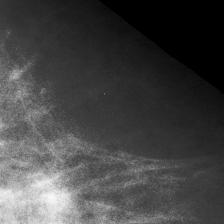

In [21]:
rbg16 = Image.open("gray.jpg").convert("RGB")
rbg16

In [22]:
np.asarray(rbg16)[:,:,0]

array([[ 54,  54,  53,  52, ...,   0,   0,   0,   0],
       [ 54,  54,  53,  52, ...,   0,   0,   0,   0],
       [ 54,  54,  53,  52, ...,   0,   0,   0,   0],
       [ 54,  54,  53,  52, ...,   0,   0,   0,   0],
       ...,
       [195, 171, 173, 188, ...,  60,  60,  60,  60],
       [194, 180, 178, 185, ...,  60,  60,  60,  60],
       [190, 194, 189, 188, ...,  59,  59,  60,  60],
       [187, 204, 198, 192, ...,  59,  59,  59,  60]], dtype=uint8)

In [23]:
print(Pil2tensor_old(rbg16).size())
Pil2tensor_old(rbg16).int()[0]

torch.Size([3, 224, 224])


tensor([[ 54,  54,  53,  ...,   0,   0,   0],
        [ 54,  54,  53,  ...,   0,   0,   0],
        [ 54,  54,  53,  ...,   0,   0,   0],
        ...,
        [194, 180, 178,  ...,  60,  60,  60],
        [190, 194, 189,  ...,  59,  60,  60],
        [187, 204, 198,  ...,  59,  59,  60]], dtype=torch.int32)

In [24]:
print(pil2tensor_new(rbg16, np.int).size())
pil2tensor_new(rbg16,np.int)[0]

torch.Size([3, 224, 224])


tensor([[ 54,  54,  53,  ...,   0,   0,   0],
        [ 54,  54,  53,  ...,   0,   0,   0],
        [ 54,  54,  53,  ...,   0,   0,   0],
        ...,
        [194, 180, 178,  ...,  60,  60,  60],
        [190, 194, 189,  ...,  59,  60,  60],
        [187, 204, 198,  ...,  59,  59,  60]])

In [25]:
print(pil2tensor_radek(rbg16, np.int).size())
pil2tensor_radek(rbg16,np.int)[0]

torch.Size([3, 224, 224])


tensor([[ 54,  54,  53,  ...,   0,   0,   0],
        [ 54,  54,  53,  ...,   0,   0,   0],
        [ 54,  54,  53,  ...,   0,   0,   0],
        ...,
        [194, 180, 178,  ...,  60,  60,  60],
        [190, 194, 189,  ...,  59,  60,  60],
        [187, 204, 198,  ...,  59,  59,  60]])

# # Is the the content correct for 16bit grayscale png
Notice that Pil2tensor truncates the 16 bit values to 8 bit and that the tensor size i wrong

allPil2tensor preserve the pixel values and the tensor size is correct

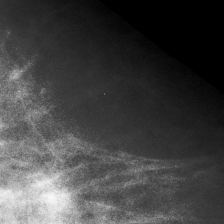

In [26]:
im16bit = Image.open("gray_16bit.png").convert("I")
im16bit

In [27]:
np.asarray(im16bit)

array([[13052, 13048, 12476, 12707, ...,     0,     0,     0,     0],
       [13680, 13091, 13019, 13238, ...,     0,     0,     0,     0],
       [13085, 12747, 13274, 13004, ...,     0,     0,     0,     0],
       [12396, 12964, 12657, 12899, ...,     0,     0,     0,     0],
       ...,
       [51303, 45715, 44217, 48575, ..., 14463, 15409, 14098, 14638],
       [47507, 44621, 46204, 47109, ..., 14546, 15133, 14347, 14767],
       [50976, 48555, 48834, 49901, ..., 13900, 14542, 15126, 14977],
       [49620, 51061, 50370, 50167, ..., 14751, 14602, 15097, 14475]], dtype=int32)

In [28]:
print(Pil2tensor_old(im16bit).size())
Pil2tensor_old(im16bit).int()

torch.Size([4, 224, 224])


tensor([[[252, 248, 188,  ...,   0,   0,   0],
         [112,  35, 219,  ...,   0,   0,   0],
         [ 29, 203, 218,  ...,   0,   0,   0],
         ...,
         [147,  77, 124,  ...,  29,  11, 175],
         [ 32, 171, 194,  ..., 206,  22, 129],
         [212, 117, 194,  ...,  10, 249, 139]],

        [[ 50,  50,  48,  ...,   0,   0,   0],
         [ 53,  51,  50,  ...,   0,   0,   0],
         [ 51,  49,  51,  ...,   0,   0,   0],
         ...,
         [185, 174, 180,  ...,  59,  56,  57],
         [199, 189, 190,  ...,  56,  59,  58],
         [193, 199, 196,  ...,  57,  58,  56]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         ...,
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0]],

        [[  0,   0,   0,  ...,   0,   0,   0],
         [  0,   0,   0,  ...,   0,   0,   0],
         [  

In [29]:
print(pil2tensor_radek(im16bit,np.int).size())
pil2tensor_radek(im16bit,np.int)

torch.Size([1, 224, 224])


tensor([[[13052, 13048, 12476,  ...,     0,     0,     0],
         [13680, 13091, 13019,  ...,     0,     0,     0],
         [13085, 12747, 13274,  ...,     0,     0,     0],
         ...,
         [47507, 44621, 46204,  ..., 15133, 14347, 14767],
         [50976, 48555, 48834,  ..., 14542, 15126, 14977],
         [49620, 51061, 50370,  ..., 14602, 15097, 14475]]])

In [30]:
print(pil2tensor_new(im16bit,np.int).size())
pil2tensor_new(im16bit,np.int)

torch.Size([1, 224, 224])


tensor([[[13052, 13048, 12476,  ...,     0,     0,     0],
         [13680, 13091, 13019,  ...,     0,     0,     0],
         [13085, 12747, 13274,  ...,     0,     0,     0],
         ...,
         [47507, 44621, 46204,  ..., 15133, 14347, 14767],
         [50976, 48555, 48834,  ..., 14542, 15126, 14977],
         [49620, 51061, 50370,  ..., 14602, 15097, 14475]]])

# Show diferent test images in rgb and grayscale

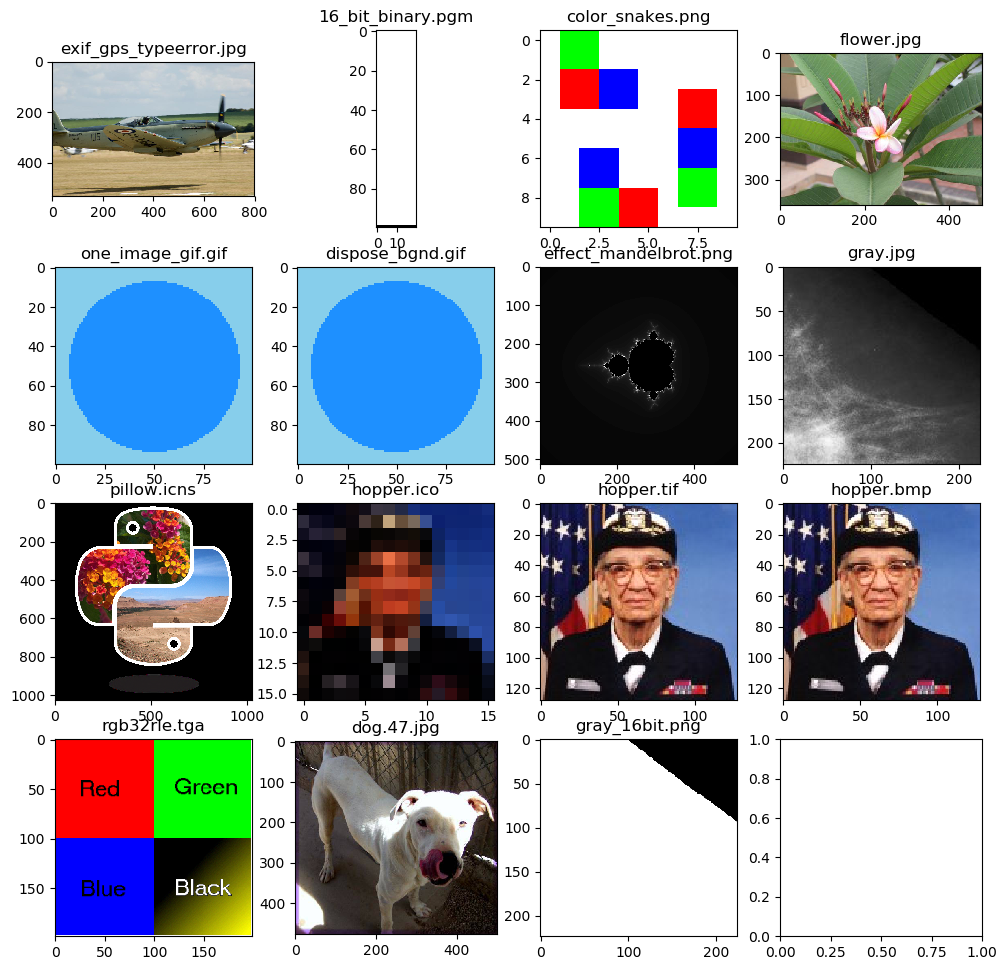

In [31]:
extensions = ('.bmp', '.gif', '.icns', '.ico', '.jpg', '.pgm', '.png', '.tga', '.tif')
files      = np.asarray( list( Path.cwd().glob("*.*") ) )
files      = files[[f.suffix in extensions for f in files]] 

ncols = 4
nrows = int( math.ceil(len(files)/float(ncols)) )

fig,axes = plt.subplots(nrows=nrows, ncols=ncols, figsize = (12,12), dpi=100 )
axes     = axes.flatten()
for i,f in enumerate(files):
    im = np.asarray(Image.open(f).convert("RGB"))
    axes[i].imshow(  im )
    axes[i].set_title(f.name)

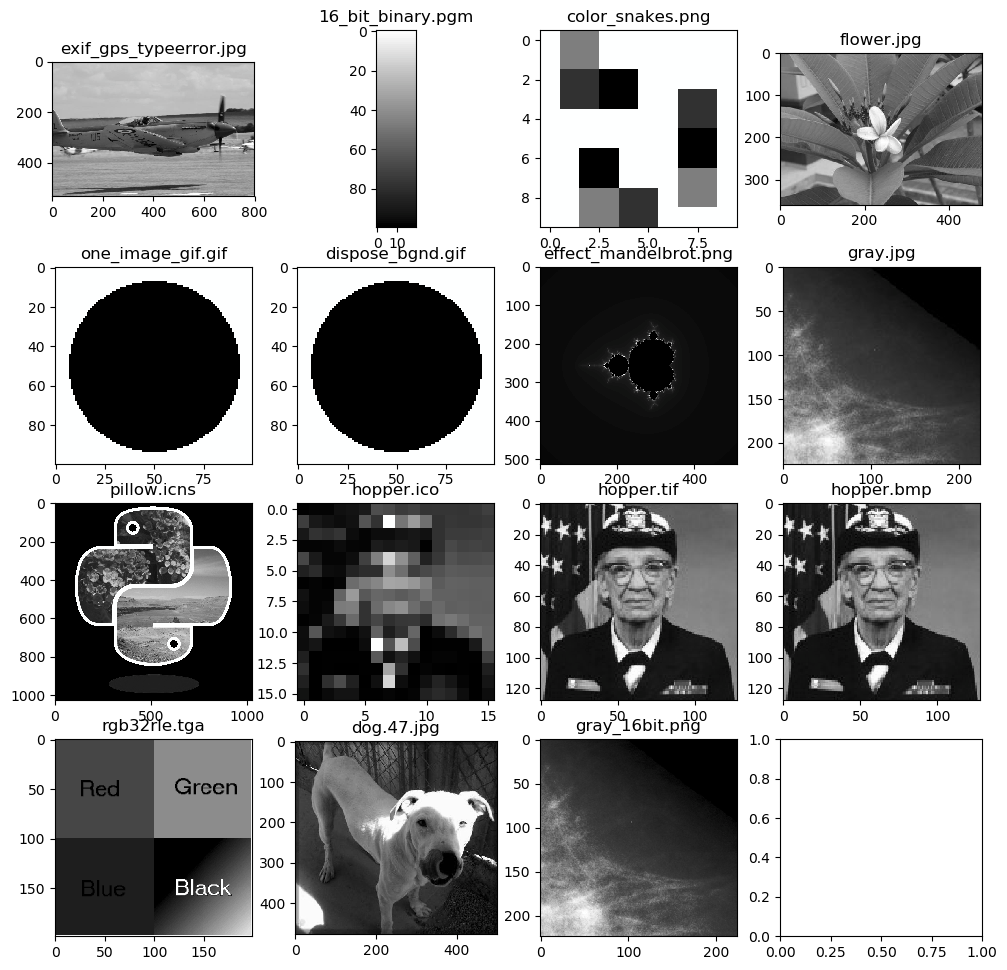

In [32]:
fig,axes = plt.subplots(nrows=nrows, ncols=ncols, figsize = (12,12), dpi=100 )
axes     = axes.flatten()
for i,f in enumerate(files):
    im = np.asarray(Image.open(f).convert("I")) / 65535.
    axes[i].imshow(  im, cmap=cmap_grey )
    axes[i].set_title(f.name)